In [10]:
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import pickle
from itertools import product, combinations
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans

from Bio.Seq import Seq
from optimization.src.oracle import *
from optimization.src.encoding_utils import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

labels = ['A', 'C', 'G', 'T', 'AG', 'CT', 'AC', 'GT', 'GC', 'AT', 'ACT', 'GCT', 'ACG', 'AGT', 'ACGT']
labels2 = ['A', 'C', 'G', 'T', 'R', 'Y', 'M', 'K', 'S', 'W', 'H', 'B', 'V', 'D', 'N']
labels4 = ['A', 'C', 'G', 'T', 'AG  (R)', 'CT (Y)', 'AC (M)', 'GT (K)', 'GC (S)', 'AT (W)', 'ACT (H)', 'GCT (B)', 'ACG (V)', 'AGT (D)', 'ACGT (N)']

labels3 = []
for i in range(12):
    labels3 += [str(i) + 'A', str(i) + 'C', str(i) + 'G', str(i) + 'T']

### For processing each individual trial

In [21]:
name = 'simple_exp25_GB1'

results = np.load('optimization/saved/' + name + '/results.npy', allow_pickle=True)
means = results.item()['means']
vars = results.item()['vars']
Xts = results.item()['Xts'].astype(int)
final_means = means[-1, :, :]
final_vars = vars[-1, :, :]
initial_encodings = Xts[0, :, :]
final_encodings = Xts[-1, :, :]
final_encodings2 = np.copy(final_encodings)

# AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(initial_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)

(88, 48, 1)


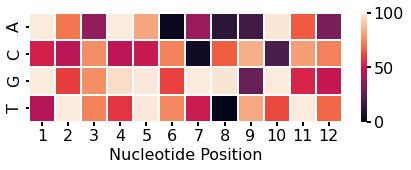

In [150]:
plt.figure(figsize = (7, 2))
sns.heatmap(data = np.sum(final_encodings2, axis = 0).reshape(-1, 4).T/240*100, vmin = 0, vmax=100, yticklabels=['A', 'C', 'G', 'T'], xticklabels=np.arange(1, 13), linewidths=2)
plt.xlabel('Nucleotide Position')
plt.savefig('nucleotides.svg')

In [24]:
name = 'swiftlib'
final_encodings = np.zeros((31, 48, 1))
max10000 = ["DYANNSGSADNS", "NHCNNSGGADNS", "VNCNNSGGADNS", "VWSNNSGGADNS", "NNCNDSGGADNS", "VHCNNSGGANNS", "VHSNNSGGANNC", "DYSNNSGGADNS", "VHANNSGGANNS", "NBCNNSGGADNS"]
max40000 = ["NNSNNSGGANNS", "NHSNNSGSADNS", "NNSNDSGSADNS", "VNSNNSGSADNS", "VHSNNSGSANNS", "NNSDNSGSADNS", "DNSNNSGSADNS", "NDSNNSGSADNS", "NHSNDSGSANNS", "NNSNNSGSANNC"]
max160000 = ["NNSNNSKSCNNS", "NNSNNSRSCNNS", "NNSNNSKSCDNS", "NHSNNSKSCNNS", "NNSNDSKSCNNS", "VNSNNSKSCNNS", "NNSNNSGSANNS", "NNSNNSRSCDNS", "NNMNNSKSCNNS", "NNSDNSKSCNNS"]
template_list = max10000 + max40000 + max160000 + ["NNKNNKNNKNNK"]

for i, encoding in enumerate(template_list):
    final_encodings[i, :, :] = seq2encoding(encoding).T

final_encodings2 = np.copy(final_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)
unique_AA_encodings = final_AA_encodings
unique_encodings = final_encodings2
unique_indices = np.arange(31)

(31, 48, 1)


In [78]:
df = pd.DataFrame(index = unique_indices)
df['Template1'] = [encoding2seq(encoding) for encoding in unique_encodings]
df['Library Size'] = [get_library_size(encoding) for encoding in unique_encodings]
df['AA Library Size'] = np.array(AA_library_sizes)[unique_indices]

In [79]:
# with open('/home/jyang4/repos/DeCOIL/optimization/saved/' + name + '/' + name + '.json', 'r') as f:
#     config = json.load(f)

with open('/home/jyang4/repos/DeCOIL/optimization/configs/defaults/DEFAULT.json', 'r') as f:
    config = json.load(f)

oracle = Oracle(config['data_config'], config['opt_config'], verbose = True)

fitness_df = pd.read_csv('/home/jyang4/repos/DeCOIL/data/GB1_fitness.csv')
fitness_df['fit'] = fitness_df['fit']/np.max(fitness_df['fit'])
dictionary = dict(zip(fitness_df['Combo'], fitness_df['fit']))

triad_df = pd.read_csv('/home/jyang4/repos/DeCOIL/data/GB1_all_triad.csv')
triad_df['ranked_zs'] = triad_df['Triad Score'].rank(ascending=False)/len(triad_df)
triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

# triad_df = pd.read_csv('/home/jyang4/repos/DeCOIL/data/TrpB_all_evmutation.csv')
# triad_df['ranked_zs'] = triad_df['EVMutation Rank'].rank(ascending=False)/len(triad_df)
# triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

final_encodings = unique_encodings

n_solutions = len(final_encodings)
results_maxes = np.zeros((n_solutions, 100))
results_means = np.zeros((n_solutions, 100))
top25 = np.zeros((n_solutions, 100))
weighted_simple_exp1 = np.zeros((n_solutions, 100))

weighted_simple = []
unweighted = []

top05 = []
unique = []

for i in range(n_solutions):
    #best_encoding = seq2encoding('TACNBCNNSAGC').reshape(1, final_encodings.shape[1], final_encodings.shape[2])
    #TACNNSNNSDCA
    #TWCDNSNNSASC

    #max 400 libraries:
    #TACNBCNNSAGC
    
    best_encoding = final_encodings[i, :, :].reshape(1, final_encodings.shape[1], final_encodings.shape[2])
    # oracle.aas2zs(oracle.sample(best_encoding), n_samples=384, seed=42 )

    means, vars, seqs = oracle.predict(best_encoding)

    #pooled = seqs.reshape((100, -1))
    # pooled = seqs.reshape((1, -1))
    # pooled_df = pd.DataFrame(pooled.T)

    # #best_df = pd.DataFrame(seqs[65,:,:])

    # best_df2 = pd.DataFrame(pooled_df[0])
    # best_df2.columns = ['Combo']
    
    # merged = best_df2.merge(fitness_df[['fit', 'Combo']], left_on = 'Combo', right_on='Combo', how='left')
    # all_fitnesses = merged['fit'].values
    
    #need to change this for the new runs with better values

    #need to fix this
    weighted_simple.append(means[0,0])

    unweighted.append(means[0,1])
    top05.append(means[0,3])
    unique.append(means[0,4])
    
    all_fitnesses = np.vectorize(dictionary.get)(seqs)
    all_fitnesses = np.array(all_fitnesses, dtype=np.float64)
    all_fitnesses = all_fitnesses.reshape((100, 384))

    all_triads = np.vectorize(triad_dictionary.get)(seqs)
    all_triads = np.array(all_triads, dtype=np.float64)
    all_triads = all_triads.reshape((100, 384))

    for j, row in enumerate(all_fitnesses):
        row = np.unique(row)
        results_maxes[i, j] = np.nanmax(row)
        results_means[i, j] = np.nansum(row)/384 #this mean is deflated because not all fitness values are present in the training set
    
    for j, row in enumerate(all_triads):
        row = np.unique(row)
        top25[i, j] = np.nansum(row > 0.75)
        weighted_simple_exp1[i, j] = np.nansum(row)

For calculating the true distribution

In [25]:
fitness_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/fitness.csv')
fitness_df['fit'] = fitness_df['fit']/np.max(fitness_df['fit'])
fitness_df['ranked_fit'] = fitness_df['fit'].rank(ascending=True)/len(fitness_df)
dictionary = dict(zip(fitness_df['Combo'], zip(fitness_df['fit'], fitness_df['ranked_fit'])))

triad_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/GB1_all_triad.csv')
triad_df['ranked_zs'] = triad_df['Triad Score'].rank(ascending=False)/len(triad_df)
triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

triad_means = []
fitness_means = []
fitness_rank_means = []
all_results = np.zeros((len(unique_AA_encodings), 21**4, 5)) #triad weight, fitness weight, fitness rank weight, frequency for all comobos, frequency only for combos included in labeled fitness

for i, AA_encoding in enumerate(unique_AA_encodings):
    AA_encoding = AA_encoding.reshape((4, 21))

    all_freqs = list(product(AA_encoding[0], AA_encoding[1], AA_encoding[2], AA_encoding[3]))
    all_combos = list(product(ALL_AAS, ALL_AAS, ALL_AAS, ALL_AAS))
    all_combos = [''.join(combo) for combo in all_combos]

    total_freqs = [np.prod(freqs) for freqs in all_freqs]
    total_triad_sum = 0
    total_fitness_sum = 0
    total_fitness_rank_sum = 0
    total_freq = 0

    for j, (freq, combo) in enumerate(zip(total_freqs, all_combos)):
        if freq != 0 and '*' not in combo:
            all_results[i,j,0] = triad_dictionary[combo] 
            all_results[i,j,3] = freq

            if combo in dictionary:
                all_results[i,j,1] = dictionary[combo][0] 
                all_results[i,j,2] = dictionary[combo][1] 
                all_results[i,j,4] = freq
                
    # triad_means.append(total_triad_sum/8916100448256) #1728 to the power of 4
    # fitness_means.append(total_fitness_sum/total_freq)
    # fitness_rank_means.append(total_fitness_rank_sum/total_freq)

In [26]:
np.save(name + '_true.npy', all_results)

In [43]:
name = 'swiftlib'
all_results = np.load(name + '_true.npy')

In [44]:
#expected value of the triad score
triad_means = np.sum(all_results[:,:,0] * all_results[:,:,3], axis = 1)/8916100448256 #1728 to the power of 4
total_freqs = np.sum(all_results[:,:,4], axis = 1)

fitness_means = np.sum(all_results[:,:,1] * all_results[:,:,4], axis = 1)/total_freqs
fitness_rank_means = np.sum(all_results[:,:,2] * all_results[:,:,4], axis = 1)/total_freqs

In [45]:
df = pd.read_csv(name + '_results.csv', index_col=0)
df['Triad Rank Expectation'] = triad_means
df['Fitness Expectation'] = fitness_means
df['Fitness Rank Expectation'] = fitness_rank_means
df

,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation
0,DYANNSGSADNS,9216.0,4536,0.763823,0.763725,0.874479,0.775833,0.475990,0.050957,0.658760,20.843803,33.262454,20.843803,0.707733,0.141176,0.810827,0.061864,0.814543
1,NHCNNSGGADNS,9216.0,4536,0.769423,0.769347,0.873099,0.759583,0.613125,0.049809,0.598350,19.811495,32.242449,19.811495,0.614051,0.057554,0.817449,0.058868,0.827078
2,VNCNNSGGADNS,9216.0,4536,0.773030,0.772954,0.873099,0.765859,0.617943,0.035164,0.464130,19.827380,32.242449,19.827380,0.579242,0.037406,0.820988,0.041230,0.793068
3,VWSNNSGGADNS,9216.0,3780,0.780787,0.780586,0.856667,0.794427,0.675911,0.048810,0.483813,19.838766,31.566529,19.838766,0.579242,0.040788,0.845759,0.057872,0.846732
4,NNCNDSGGADNS,9216.0,4860,0.815660,0.815532,0.865000,0.816719,0.651120,0.045029,0.596812,20.006927,31.958837,20.006927,0.634195,0.051718,0.866168,0.053882,0.828146
5,VHCNNSGGANNS,9216.0,3969,0.730508,0.730410,0.871901,0.695078,0.559089,0.034706,0.494825,19.322027,32.056082,19.322027,0.579242,0.035770,0.785513,0.041026,0.777908
6,VHSNNSGGANNC,9216.0,4095,0.765217,0.765166,0.904349,0.727370,0.615417,0.037130,0.459686,20.152853,33.325472,20.152853,0.511957,0.037066,0.817968,0.042768,0.813047
7,DYSNNSGGADNS,9216.0,3024,0.767939,0.767939,0.840729,0.780286,0.685521,0.055158,0.598350,19.453293,30.828429,19.453293,0.621185,0.048074,0.847656,0.066995,0.872413
8,VHANNSGGANNS,9216.0,3969,0.727805,0.727706,0.871901,0.688359,0.545078,0.037055,0.479270,19.282360,32.056082,19.282360,0.570969,0.035267,0.782093,0.043484,0.797859
9,NBCNNSGGADNS,9216.0,4158,0.765191,0.765166,0.864870,0.757630,0.620703,0.045497,0.579242,19.647348,31.904079,19.647348,0.646607,0.053276,0.820880,0.053706,0.826587


In [46]:
df.to_csv(name + '_results.csv')

In [60]:
all_results1 = np.load('simple_exp010_GB1_true.npy')
all_results2 = np.load('simple_exp1_GB1_true.npy')
all_results3 = np.load('simple_exp25_GB1_true.npy')
all_results4 = np.load('swiftlib_true.npy')

In [61]:
def make_histplot(all_results, index):
    plt.subplot(1, 2, 1)
    sns.histplot(x=all_results[index][:,0], weights=all_results[index][:,3], binwidth = 0.05,stat='percent', element="step", fill=False)
    plt.xlabel('Normalized Triad Rank')

    plt.subplot(1, 2, 2)
    sns.histplot(x=all_results[index][:,2], weights=all_results[index][:,3], binwidth = 0.05,stat='percent', element="step", fill=False)
    plt.xlabel('Normalized Fitness Rank')
    #index 0, 1 ,2 ,3 are respectively triad rank, fitness, fitness rank, and frequency

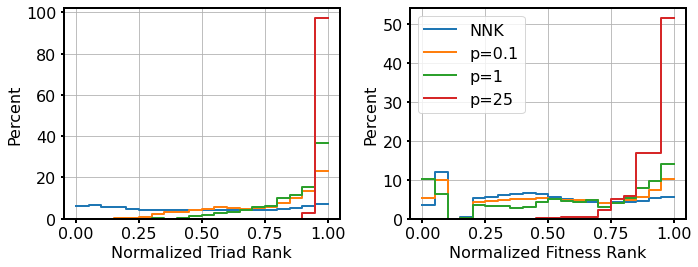

In [63]:
plt.figure(figsize=(10, 4))
make_histplot(all_results4, -1) #NNKNNKNNKNNK
make_histplot(all_results1, 2) #VDBWKKRVBDNY from exp010
make_histplot(all_results2, 0) #DTRNDYRVHVWC from exp1
make_histplot(all_results3, 0) #VTVNDBRGYDYR from exp25	
plt.subplot(1, 2, 1)
plt.grid()
plt.subplot(1, 2, 2)
plt.grid()
plt.tight_layout()
plt.legend(['NNK', 'p=0.1', 'p=1', 'p=25'])
#plt.savefig('histogram.svg')

True fitness distribution for TrpB

In [57]:
templates = ['NNKNNKNNKNNK', 'YWYVNBDKSDSY', 'TWYNNBNYBWCY', 'YWYDBSNNBTCN']
final_encodings = np.zeros((len(templates), 48, 1))

for i, encoding in enumerate(templates):
    final_encodings[i, :, :] = seq2encoding(encoding).T

final_encodings2 = np.copy(final_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)

unique_AA_encodings = final_AA_encodings

(4, 48, 1)


In [58]:
# fitness_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/fitness.csv')
# fitness_df['fit'] = fitness_df['fit']/np.max(fitness_df['fit'])
# fitness_df['ranked_fit'] = fitness_df['fit'].rank(ascending=True)/len(fitness_df)
# dictionary = dict(zip(fitness_df['Combo'], zip(fitness_df['fit'], fitness_df['ranked_fit'])))

triad_df = pd.read_csv('/home/jyang4/repos/DeCOIL/data/TrpB_all_evmutation.csv')
triad_df['ranked_zs'] = triad_df['EVMutation Rank'].rank(ascending=False)/len(triad_df)
triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

triad_means = []
fitness_means = []
fitness_rank_means = []
all_results = np.zeros((len(unique_AA_encodings), 21**4, 4)) #four columns, 3 are for weights, 1 is for the frequency

for i, AA_encoding in enumerate(unique_AA_encodings):
    AA_encoding = AA_encoding.reshape((4, 21))

    all_freqs = list(product(AA_encoding[0], AA_encoding[1], AA_encoding[2], AA_encoding[3]))
    all_combos = list(product(ALL_AAS, ALL_AAS, ALL_AAS, ALL_AAS))
    all_combos = [''.join(combo) for combo in all_combos]

    total_freqs = [np.prod(freqs) for freqs in all_freqs]
    total_triad_sum = 0
    total_fitness_sum = 0
    total_fitness_rank_sum = 0
    total_freq = 0

    for j, (freq, combo) in enumerate(zip(total_freqs, all_combos)):
        if freq != 0 and '*' not in combo:
            all_results[i,j,0] = triad_dictionary[combo]  
            
            all_results[i,j,3] = freq

In [106]:
rate_df1 = pd.read_csv('/home/jyang4/repos/DeCOIL/230307_indole_rate_data.csv')
rate_df2 = pd.read_csv('/home/jyang4/repos/DeCOIL/230228_indole_rate_data.csv')
rate_df = pd.concat((rate_df1, rate_df2))

def truncate(a):
    return a[-1]

rate_df['Plate'] = rate_df['Plate'].astype(str).apply(truncate)
rate_df

,Unnamed: 0,Library,Plate,Well,Rate,Type,Column,Row
0,0,lib3,1,A01,0.034055,Variant,1,A
1,1,lib3,1,A02,0.355438,Variant,2,A
2,2,lib3,1,A03,0.021718,Variant,3,A
3,3,lib3,1,A04,-0.008277,Variant,4,A
4,4,lib3,1,A05,-0.015387,Variant,5,A
...,...,...,...,...,...,...,...,...
475,475,NNKlibs,1,H08,0.043698,Variant,8,H
476,476,NNKlibs,1,H09,0.055622,Variant,9,H
477,477,NNKlibs,1,H10,0.030952,Negative,10,H
478,478,NNKlibs,1,H11,0.039313,Variant,11,H


In [107]:
#normalize rate of Trp formation to that of parents on each plate
for lib in ['NNKlibs', 'lib1', 'lib2', 'lib3']:
    for plate in ['1', '2', '3', '4', '5']:
        rate_df.loc[(rate_df.Library == lib) & (rate_df.Plate == plate), 'Rate'] *= 1/np.mean(rate_df.loc[(rate_df.Library == lib) & (rate_df.Plate == plate) & (rate_df.Type == 'Parent'), 'Rate'])

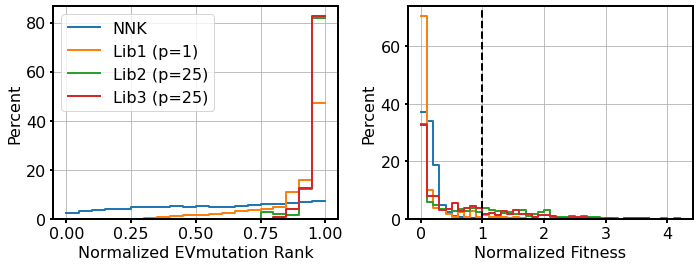

In [116]:
plt.figure(figsize=(10, 4))
mean_parent_rate = np.mean(rate_df[(rate_df['Type'] == 'Parent')]['Rate'].values)

plt.subplot(1, 2, 1)
plt.xlabel('Normalized EVmutation Rank')
plt.grid()
for i in range(4):
    sns.histplot(x=all_results[i][:,0], weights=all_results[i][:,3], binwidth = 0.05,stat='percent', element="step", fill=False)
plt.legend(['NNK', 'Lib1 (p=1)', 'Lib2 (p=25)', 'Lib3 (p=25)'])

plt.subplot(1, 2, 2)
plt.xlabel(r'Normalized Fitness')
plt.grid()

colors = ['tab:orange', 'tab:green', 'tab:red']

for lib in ['NNKlibs', 'lib1', 'lib2', 'lib3']:
    data = rate_df[(rate_df['Library'] == lib) & (rate_df['Type'] == 'Variant')]['Rate'].values
    data  = np.where(data<0, 0, data) #make negative values zeros
    data = data[:384] #take the first 384
    sns.histplot(x=data, binwidth = 0.1,stat='percent', element="step", fill=False)

plt.axvline(x=1, ls='--', color='k') #mean parent fitness
plt.tight_layout()
#plt.savefig('histogram_TrpB.svg')

In [13]:
def trajectory_plot2(means, fig, ax1, ax2, color):
    overall_means = np.mean(means, axis = 1)
    overall_stds = np.std(means, axis = 1)
    
    iters = 120
    ax1.set_xlim(0, iters)
    ax2.set_xlim(0, iters)
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    #ax1.set_ylim(0, 160000)
    #ax2.set_ylim(0, 384)
    ax1.plot(overall_means[:,0], color=color)
    ax1.fill_between(list(range(iters)), overall_means[:,0] - overall_stds[:,0], overall_means[:,0] + overall_stds[:,0], alpha=0.3, facecolor=color)
    # ax1.plot(overall_means[:,2], 'royalblue')
    # ax1.fill_between(list(range(iters)), overall_means[:,2] - overall_stds[:,2], overall_means[:,2] + overall_stds[:,2], alpha=0.3, facecolor='royalblue')
    # plt.legend(['Score', 'Raw Score'], loc = 'lower right')

    ax2.plot(overall_means[:,3]/384, '--', color=color)
    ax2.plot(overall_means[:,4]/384, '-', color=color)
    ax2.fill_between(list(range(iters)), (overall_means[:,4] - overall_stds[:,4])/384, (overall_means[:,4] + overall_stds[:,4])/384, alpha=0.3, facecolor=color)

    ax2.fill_between(list(range(iters)), (overall_means[:,3] - overall_stds[:,3])/384, (overall_means[:,3] + overall_stds[:,3])/384, alpha=0.3, facecolor=color)

    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Weighted Simple Coverage")
    #ax1.tick_params(axis="y", labelcolor='r')

    ax2.set_ylabel("Fraction of Library")
    ax2.set_xlabel("Iterations")
    #ax2.tick_params(axis="y", labelcolor='b')

    plt.legend(['Above 95th Percentile', 'Unique'], loc = 'lower right')
    #plt.savefig('trajectory.jpg', dpi=500)
    plt.tight_layout()

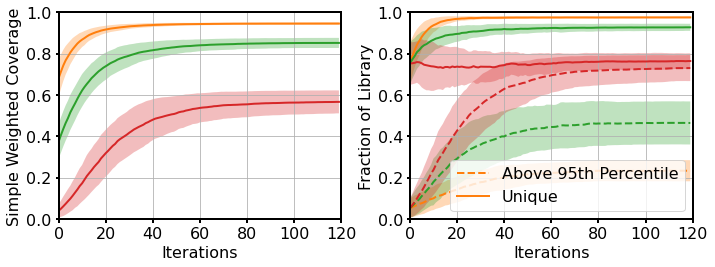

In [62]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
ax2.grid()
ax1.grid()
#colors = ['mediumturquoise', 'teal', 'darkslategrey']
colors = ['tab:orange', 'tab:green', 'tab:red']
for name, color in zip(['simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1'], colors):
    
    results = np.load('optimization/saved/' + name + '/results.npy', allow_pickle=True)
    means = results.item()['means']
    trajectory_plot2(means, fig, ax1, ax2, color)
ax1.set_xticks(np.arange(0, 140, step=20))
ax2.set_xticks(np.arange(0, 140, step=20))
plt.savefig('trajectory.svg')

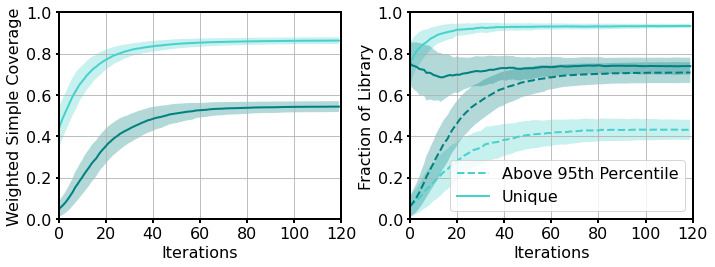

In [115]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)
ax2.grid()
ax1.grid()
colors = ['mediumturquoise', 'teal']
#colors = ['tab:blue', 'tab:orange', 'tab:red']
for name, color in zip(['simple_exp1_TrpB', 'simple_exp25_TrpB'], colors):
    
    results = np.load('optimization/saved/' + name + '/results.npy', allow_pickle=True)
    means = results.item()['means']
    trajectory_plot2(means, fig, ax1, ax2, color)
ax1.set_xticks(np.arange(0, 140, step=20))
ax2.set_xticks(np.arange(0, 140, step=20))
plt.savefig('trajectory_TrpB.svg')

In [63]:
# #for TrpB
# #for entries without fitness labels
# weighted_simple_exp1_flat = np.mean(weighted_simple_exp1, axis = 1)
# top25_flat = np.mean(top25, axis = 1)

# #skip weighted full for now
# columns = ['Weighted Simple', 'Weighted Simple exp1', 'frac_unique', 'frac_top25', 'frac_top5']
# for column, metric in zip(columns, [weighted_simple, weighted_simple_exp1_flat/384, np.array(unique)/384, np.array(top25_flat)/384, np.array(top05)/384]):
#     df[column] = metric
#     # print(np.mean(metric))
#     # print(np.std(metric))
#     # print('')

In [80]:
weighted_simple_exp1_flat = np.mean(weighted_simple_exp1, axis = 1)
results_means_flat = np.median(results_means, axis = 1)
results_maxes_flat = np.median(results_maxes, axis = 1)
top25_flat = np.mean(top25, axis = 1)

#skip weighted full for now
columns = ['Weighted Simple', 'Weighted Simple exp1', 'frac_unique', 'frac_top25', 'frac_top5', 'Sampled Median Mean', 'Sampled Median Max']
for column, metric in zip(columns, [weighted_simple, weighted_simple_exp1_flat/384, np.array(unique)/384, np.array(top25_flat)/384, np.array(top05)/384, results_means_flat, results_maxes_flat]):
    df[column] = metric
    # print(np.mean(metric))
    # print(np.std(metric))
    # print('')

In [4]:
#if full coverage is available
# results = np.load('/home/jyang4/repos/DeCOIL/optimization/saved/full_exp1/full_' + name[7:-4] + '_hamming_GB1/results.npy', allow_pickle=True)
# means = results.item()['means']
# vars = results.item()['vars']
# Xts = results.item()['Xts'].astype(int)
# final_means = means[-1, :, :]
# final_vars = vars[-1, :, :]
# weighted_full = final_means[:,0][unique_indices]
# unweighted_full = final_means[:,1][unique_indices]
# df['Weighted Full'] = weighted_full
# df['Unweighted Full'] = unweighted_full
# df['Weighted Full exp1'] = weighted_full

#comment this out if it was already exp1
results = np.load('/home/jyang4/repos/DeCOIL/optimization/saved/full_exp1_manhattan_MSA_GB1/results.npy', allow_pickle=True)
means = results.item()['means']
vars = results.item()['vars']
Xts = results.item()['Xts'].astype(int)
final_means = means[-1, :, :]
final_vars = vars[-1, :, :]
weighted_full = final_means[:,0][unique_indices]
unweighted_full = final_means[:,1][unique_indices]
df2['Weighted Full MSA Manhattan'] = weighted_full
df2['Unweighted Full MSA Manhattan'] = unweighted_full
#df['Weighted Full exp1'] = weighted_full

In [74]:
#if mlde results are available
results = np.load('MLDE_lite/saved/boosting_swiftlib_GB1/mlde_results.npy', allow_pickle=True)
#results = np.load('MLDE_lite/saved/boosting_' + name + '/mlde_results.npy', allow_pickle=True)

maxes = results.item()['maxes']
means = results.item()['means']
ndcgs = results.item()['ndcgs']
top_seqs = results.item()['top_seqs']
labelled = results.item()['labelled']
unique = results.item()['unique']

maxes2 = maxes.reshape(maxes.shape[3], maxes.shape[4]).T
means2 = means.reshape(means.shape[3], means.shape[4]).T
ndcgs2 = ndcgs.reshape(ndcgs.shape[3], ndcgs.shape[4]).T
unique2 = unique.reshape(unique.shape[3], unique.shape[4]).T

all_maxes_medians = np.median(maxes2, axis = 0).reshape(1, -1)
all_means_medians = np.median(means2, axis = 0).reshape(1, -1)
df['Boosting Median Max'] = all_maxes_medians.T[unique_indices]
df['Boosting Median Mean'] = all_means_medians.T[unique_indices]

In [81]:
df

,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max
184,MSMKRMMRHYMK,6144,864,0.179786,0.179786,0.482760,0.056823,0.003932,0.000216,0.003476
225,MSDSRSVKKHWS,13824,1680,0.359377,0.359377,0.750052,0.169479,0.073203,0.003648,0.260759
129,YBRHSNRBBYRB,62208,2352,0.277383,0.277383,0.671302,0.159323,0.053932,0.004962,0.335309
102,WMBWKYSMVKBM,13824,1152,0.373175,0.373175,0.654323,0.255078,0.019922,0.006829,0.506426
41,HRRMKNVHVVKK,62208,2275,0.276185,0.276176,0.644557,0.107161,0.003646,0.003649,0.342678
...,...,...,...,...,...,...,...,...,...,...
92,KMHRYBHYDYBM,31104,1470,0.232853,0.232853,0.658958,0.070156,0.003125,0.001749,0.257716
155,RMHHBNDMWRVB,93312,5346,0.483063,0.483048,0.827135,0.268854,0.028516,0.002825,0.245715
219,SMHWNSRSMWMR,12288,1560,0.377986,0.377986,0.586302,0.252604,0.089740,0.003211,0.218795
13,RMYWKMSSBNWD,18432,1456,0.407127,0.407127,0.666224,0.334505,0.159557,0.005914,0.307658


In [7]:
df.to_csv(name + '_results.csv')
#df.to_csv('test.csv')

### Combining all of the results

In [51]:
df1 = pd.read_csv('simple_exp010_GB1_results.csv')
df2 = pd.read_csv('simple_exp1_GB1_results.csv')
df3 = pd.read_csv('simple_exp25_GB1_results.csv')
df4 = pd.read_csv('swiftlib_results.csv')
df5 = pd.read_csv('initial_results.csv')
df6 = pd.read_csv('simple_exp1_TrpB_results.csv')
df7 = pd.read_csv('simple_exp25_TrpB_results.csv')

df1['descriptor'] = 'simple_exp010_GB1'
df2['descriptor'] = 'simple_exp1_GB1'
df3['descriptor'] = 'simple_exp25_GB1'
df4['descriptor'] = 'swiftlib'
df5['descriptor'] = 'initial'
df6['descriptor'] = 'simple_exp1_TrpB'
df7['descriptor'] = 'simple_exp25_TrpB'

df4.loc[:10,'descriptor'] = 'swiftlib_max10000'
df4.loc[10:20,'descriptor'] = 'swiftlib_max40000'
df4.loc[20:30,'descriptor'] = 'swiftlib_max160000'
df4.loc[30,'descriptor'] = 'random'

In [62]:
# df7 = df7.sort_values(by="Weighted Simple", ascending = False).reset_index()
# df7
# # df6[df6['Template1'] == 'YWYVNBDKSDSY']
# df7[df7['Template1'] == 'TWYNNBNYBWCY']

,index,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Weighted Full,Unweighted Full,descriptor
0,4,7,TAYVTDNNBNNY,27648,1260,0.589445,0.783035,0.793698,0.793698,0.784844,4.541195,28.618438,simple_exp25_TrpB
1,0,13,TAYDTRNNBNNY,18432,1260,0.588319,0.785901,0.796901,0.796901,0.783724,4.552668,28.754481,simple_exp25_TrpB
2,3,105,TAYVTSNBBNNB,20736,1092,0.585689,0.698039,0.761198,0.706042,0.754818,4.474504,27.430982,simple_exp25_TrpB
3,5,82,TACVTBNNTNNB,6912,1260,0.584791,0.734308,0.793620,0.744245,0.781198,4.495846,28.601370,simple_exp25_TrpB
4,1,204,TACDTRNHBNNT,3456,1020,0.577394,0.752817,0.762552,0.762552,0.747396,4.521001,27.740993,simple_exp25_TrpB
5,2,215,TAYVTSNHHNNB,20736,1344,0.576412,0.712316,0.770677,0.721823,0.752031,4.493535,27.814647,simple_exp25_TrpB
6,42,11,NNBVTDNBBTCK,31104,1092,0.559275,0.701315,0.754349,0.710599,0.748411,4.193039,27.281968,simple_exp25_TrpB
7,18,207,TATDYRDTKNNB,3456,735,0.558408,0.630386,0.699635,0.636328,0.699635,4.328140,25.396424,simple_exp25_TrpB
8,40,9,NNBDTRNBBAGT,10368,1092,0.558194,0.705601,0.758594,0.715234,0.749792,4.209100,27.497764,simple_exp25_TrpB
9,19,192,TAYDYRNTBNNB,13824,735,0.556401,0.617806,0.687005,0.623255,0.687005,4.286202,24.828695,simple_exp25_TrpB


In [52]:
all_data = pd.concat([df1, df2, df3, df4, df5, df6, df7])
all_data.replace(0, np.nan, inplace=True)
all_data

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,...,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,descriptor,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan
0,99.0,VDBVDSDVTVWS,52488.0,13520,0.946120,0.741118,0.976979,0.591797,0.205599,0.006036,...,22.419638,0.570969,0.158158,0.761279,0.006574,0.509794,simple_exp010_GB1,NaN,NaN,NaN
1,44.0,VDBVDBKSBDNT,104976.0,9295,0.953876,0.847597,0.967969,0.824167,0.350573,0.028639,...,23.456785,0.707733,0.248362,0.876045,0.032211,0.697179,simple_exp010_GB1,NaN,NaN,NaN
2,50.0,VDBWKKRVBDNY,93312.0,10296,0.943730,0.743733,0.973411,0.584297,0.227891,0.016031,...,22.438469,0.689580,0.233212,0.763522,0.018213,0.578893,simple_exp010_GB1,NaN,NaN,NaN
3,156.0,VDBDNYDVYVWK,139968.0,11440,0.945158,0.744699,0.975208,0.598203,0.211589,0.008458,...,22.444014,0.588027,0.206781,0.766282,0.009184,0.533863,simple_exp010_GB1,NaN,NaN,NaN
4,136.0,VDBDNCDVYRNB,139968.0,13728,0.946427,0.745614,0.976927,0.605339,0.210911,0.019686,...,22.690719,0.825004,0.377379,0.765674,0.021773,0.609721,simple_exp010_GB1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,224.0,NNYDTRNNTTCB,9216.0,900,0.552219,0.754364,0.785104,0.766536,0.761693,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,simple_exp25_TrpB,NaN,NaN,NaN
53,14.0,NNCVTVNNBAGC,6912.0,1260,0.555881,0.763094,0.791849,0.775443,0.771042,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,simple_exp25_TrpB,NaN,NaN,NaN
54,216.0,NNCVNBNTHTCH,20736.0,960,0.503413,0.752640,0.788359,0.769401,0.706745,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,simple_exp25_TrpB,NaN,NaN,NaN
55,211.0,NNTNBBDTDTCY,10368.0,975,0.519679,0.702727,0.774141,0.715833,0.698255,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,simple_exp25_TrpB,NaN,NaN,NaN


In [53]:
all_data.to_csv('combined_results.csv')

## Plotting and analysis

In [54]:
df = pd.read_csv('combined_results.csv', index_col=0)
#df = pd.read_csv('simple_stochastic_lib_results.csv', index_col=0)
order = ['initial', 'simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1', 'swiftlib_max160000', 'swiftlib_max40000', 'swiftlib_max10000', 'random']

In [11]:
df[df['descriptor'] == 'simple_exp25_GB1'].describe()

,Unnamed: 0,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,...,Unweighted Full,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan
count,87.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,...,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,0.0,0.0,0.0
mean,81.114943,15844.909091,1101.727273,0.541722,0.748535,0.762064,0.761621,0.708804,0.054365,0.537213,...,27.907249,18.402757,0.627627,0.088018,0.921135,0.073465,0.895034,NaN,NaN,NaN
std,61.959744,11131.747796,292.270412,0.067568,0.037744,0.036858,0.036941,0.074391,0.018636,0.082819,...,1.400005,0.901523,0.116023,0.084348,0.037904,0.024012,0.057508,NaN,NaN,NaN
min,1.000000,1728.000000,594.000000,0.343092,0.646655,0.667240,0.666510,0.513359,0.010847,0.285896,...,23.985585,15.595958,0.454980,0.025546,0.826234,0.016998,0.683967,NaN,NaN,NaN
25%,29.000000,6912.000000,864.000000,0.543230,0.725569,0.738164,0.738164,0.693887,0.044186,0.500772,...,27.208373,17.973783,0.579242,0.033336,0.900226,0.060991,0.887018,NaN,NaN,NaN
50%,71.000000,13824.000000,1080.000000,0.563128,0.747868,0.762878,0.761419,0.730234,0.053114,0.570969,...,28.161551,18.692498,0.596812,0.038393,0.927324,0.073345,0.907952,NaN,NaN,NaN
75%,124.500000,20736.000000,1269.000000,0.585855,0.779191,0.793073,0.791823,0.761784,0.065917,0.579242,...,28.874493,19.007873,0.627310,0.156066,0.957823,0.086573,0.931523,NaN,NaN,NaN
max,216.000000,62208.000000,1944.000000,0.612282,0.810631,0.827240,0.827057,0.791172,0.100487,0.707733,...,30.339899,19.591053,1.000000,0.318779,0.984978,0.131769,0.964489,NaN,NaN,NaN


getting tSNE embedding

In [3]:
templates = df['Template1'].values
all_encodings = np.zeros((len(templates), 48, 1))

for i, encoding in enumerate(templates):
    all_encodings[i, :, :] = seq2encoding(encoding).T

_, _, all_AA_encodings, _, _ = get_AA_encodings(all_encodings)

np.random.seed(42)
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(all_AA_encodings[:,:,0])
df['tSNE1'] = transformed[:,0]
df['tSNE2'] = transformed[:,1]

(903, 48, 1)


/home/jyang4/miniconda3/envs/ProtGraphR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtGraphR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


getting clusters

In [4]:
#df[:10].describe()
optimized_embeddings = df[df['descriptor'].isin(['simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1'])][['tSNE1','tSNE2']].values

model = KMeans(8)
clusters = model.fit_predict(optimized_embeddings)
clusters = np.array(clusters, dtype=str)

df['cluster'] = np.nan
df.loc[df['descriptor'].isin(['simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1']),['cluster']] = clusters

In [5]:
#get one example from each cluster
indices = [0, 2, 3, 5, 4]
first_df = df.groupby("cluster").nth(10)
templates = first_df['Template1'].values[indices]
final_encodings = np.zeros((len(templates), 48, 1))

for i, encoding in enumerate(templates):
    final_encodings[i, :, :] = seq2encoding(encoding).T

final_encodings2 = np.copy(final_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)

(5, 48, 1)


In [6]:
first_df

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,...,Boosting Median Mean,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,descriptor,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan,tSNE1,tSNE2
cluster,,,,,,,,,,,,,,,,,,,,,
0,7.0,VDBDBKRGYDNY,46656.0,3432,0.874341,0.874341,0.922005,0.912891,0.572995,0.024721,...,0.192166,0.917149,0.027900,0.709404,simple_exp1_GB1,35.0,203.932821,408.185391,10.342929,40.022202
1,131.0,VTNNDYRVBRNT,41472.0,3456,0.816279,0.816138,0.928958,0.799505,0.349635,0.038520,...,0.280936,0.817837,0.047022,0.731820,simple_exp1_GB1,5.0,204.797669,409.866909,1.847378,11.899185
2,76.0,DTVDNSGGGDNY,5184.0,990,0.577836,0.730685,0.739323,0.739323,0.723958,0.084284,...,0.045608,0.912636,0.116550,0.956672,simple_exp25_GB1,NaN,NaN,NaN,40.486141,18.760948
3,43.0,NDYDNYGSSDNY,55296.0,2904,0.857766,0.857766,0.929427,0.880078,0.472682,0.057484,...,0.151227,0.878336,0.065401,0.803537,simple_exp1_GB1,85.0,199.888892,400.729213,-48.697548,19.136366
4,79.0,DBKVDSDVCDYV,52488.0,9984,0.945002,0.776457,0.969245,0.655599,0.248229,0.021324,...,0.383818,0.791874,0.023730,0.647697,simple_exp010_GB1,NaN,NaN,NaN,-0.439350,-0.676524
5,63.0,NNTRNKKSBVWS,36864.0,9000,0.949046,0.800668,0.971250,0.739557,0.298594,0.010116,...,0.147493,0.774819,0.011417,0.610565,simple_exp010_GB1,NaN,NaN,NaN,-18.014944,16.907162
6,2.0,VWNVDBNRTRNB,124416.0,12480,0.944596,0.732349,0.976927,0.581094,0.188021,0.019431,...,0.393782,0.707616,0.022583,0.618601,simple_exp010_GB1,NaN,NaN,NaN,-14.760879,5.052133
7,17.0,VWSVDSDBSDYV,69984.0,12480,0.946425,0.756162,0.974974,0.622266,0.245208,0.026340,...,0.381256,0.777452,0.028184,0.681329,simple_exp010_GB1,NaN,NaN,NaN,-12.353449,6.633054


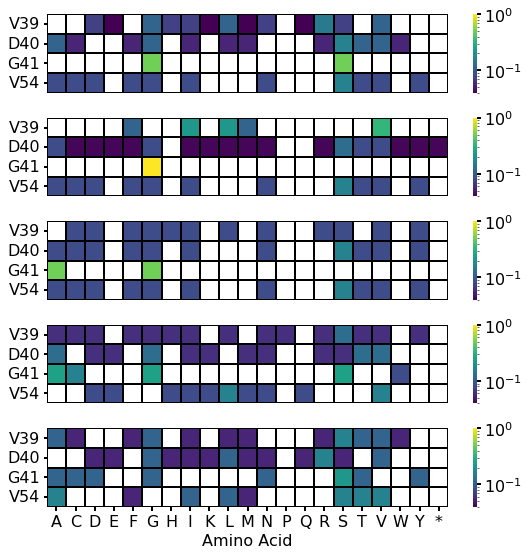

In [157]:
labels = ['V39', 'D40', 'G41', 'V54']

plt.figure(figsize = (8, 1.6*len(templates)))

for i in range(len(templates)):

    data = final_AA_encodings[i,:,0].reshape((4,21))
    plt.subplot(len(templates),1,i+1)
    #plt.title('Cluster ' + str(indices[i]))
    
    if i+1 == len(templates):
        sns.heatmap(data/1728, yticklabels=labels, xticklabels=ALL_AAS, linewidths=2, linecolor='k',cmap = 'viridis',  norm=LogNorm(vmin = 0.04, vmax = 1))
        plt.xlabel('Amino Acid')
    else:
        sns.heatmap(data/1728, yticklabels=labels, xticklabels=False, linewidths=2, linecolor='k',cmap = 'viridis',  norm=LogNorm(vmin = 0.04, vmax = 1))

plt.tight_layout()
plt.savefig('AAs.svg')

(3, 48, 1)


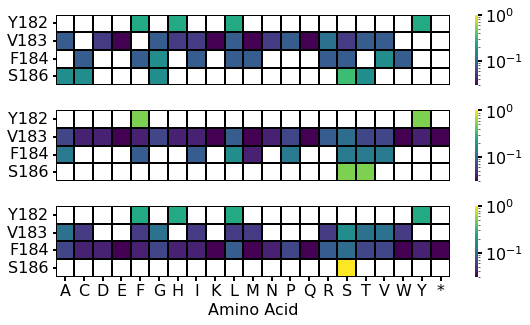

In [8]:
templates = ['YWYVNBDKSDSY', 'TWYNNBNYBWCY', 'YWYDBSNNBTCN']
final_encodings = np.zeros((len(templates), 48, 1))

for i, encoding in enumerate(templates):
    final_encodings[i, :, :] = seq2encoding(encoding).T

final_encodings2 = np.copy(final_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)

labels = ['Y182', 'V183', 'F184', 'S186']

plt.figure(figsize = (8, 1.6*len(templates)))

for i in range(len(templates)):

    data = final_AA_encodings[i,:,0].reshape((4,21))
    plt.subplot(len(templates),1,i+1)
    #plt.title('Cluster ' + str(indices[i]))
    
    if i+1 == len(templates):
        sns.heatmap(data/1728, yticklabels=labels, xticklabels=ALL_AAS, linewidths=2, linecolor='k',cmap = 'viridis',  norm=LogNorm(vmin = 0.03, vmax = 1))
        plt.xlabel('Amino Acid')
    else:
        sns.heatmap(data/1728, yticklabels=labels, xticklabels=False, linewidths=2, linecolor='k',cmap = 'viridis',  norm=LogNorm(vmin = 0.03, vmax = 1))

plt.tight_layout()
plt.savefig('AAs_TrpB.svg')

In [7]:
selected = first_df.iloc[indices,:]
selected

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,...,Boosting Median Mean,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,descriptor,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan,tSNE1,tSNE2
cluster,,,,,,,,,,,,,,,,,,,,,
0,7.0,VDBDBKRGYDNY,46656.0,3432,0.874341,0.874341,0.922005,0.912891,0.572995,0.024721,...,0.192166,0.917149,0.027900,0.709404,simple_exp1_GB1,35.0,203.932821,408.185391,10.342929,40.022202
2,76.0,DTVDNSGGGDNY,5184.0,990,0.577836,0.730685,0.739323,0.739323,0.723958,0.084284,...,0.045608,0.912636,0.116550,0.956672,simple_exp25_GB1,NaN,NaN,NaN,40.486141,18.760948
3,43.0,NDYDNYGSSDNY,55296.0,2904,0.857766,0.857766,0.929427,0.880078,0.472682,0.057484,...,0.151227,0.878336,0.065401,0.803537,simple_exp1_GB1,85.0,199.888892,400.729213,-48.697548,19.136366
5,63.0,NNTRNKKSBVWS,36864.0,9000,0.949046,0.800668,0.971250,0.739557,0.298594,0.010116,...,0.147493,0.774819,0.011417,0.610565,simple_exp010_GB1,NaN,NaN,NaN,-18.014944,16.907162
4,79.0,DBKVDSDVCDYV,52488.0,9984,0.945002,0.776457,0.969245,0.655599,0.248229,0.021324,...,0.383818,0.791874,0.023730,0.647697,simple_exp010_GB1,NaN,NaN,NaN,-0.439350,-0.676524


/home/jyang4/miniconda3/envs/ProtGraphR/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


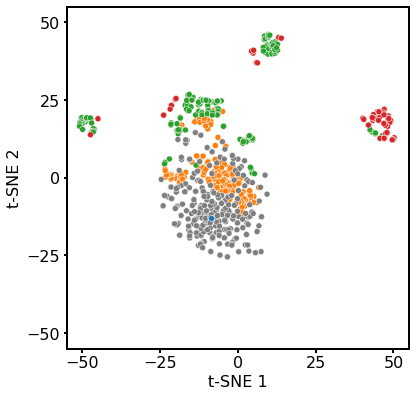

In [166]:
font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

plt.figure(figsize=(6,6))

columns = ['descriptor']
order = ['initial', 'simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1', 'random']
df_subset = df[df['descriptor'].isin(order)]
colors = ['tab:gray', 'tab:orange', 'tab:green', 'tab:red', 'tab:blue']

for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    sns.scatterplot(data=df_subset, x = 'tSNE1', y = 'tSNE2', hue=column,  palette=colors, hue_order=order, legend=False)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.xlim(-55, 55)
    plt.ylim(-55, 55)
    plt.xticks(np.arange(-50, 60, 25))
    plt.yticks(np.arange(-50, 60, 25))

sns.scatterplot(df_subset[df_subset['descriptor'] == 'random']['tSNE1'], df_subset[df_subset['descriptor'] == 'random']['tSNE2'], color='tab:blue')

#plt.plot(selected['tSNE1'][4], selected['tSNE2'][4], 's')

plt.tight_layout()
#plt.savefig('tSNE.svg')

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,...,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,descriptor,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan,tSNE1,tSNE2,cluster
30,30.0,NNKNNKNNKNNK,1048576.0,194481,0.440205,0.440164,0.878568,0.24763,0.063255,0.008781,...,0.424639,0.010481,0.517968,random,NaN,NaN,NaN,-8.716493,-12.786354,NaN


findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


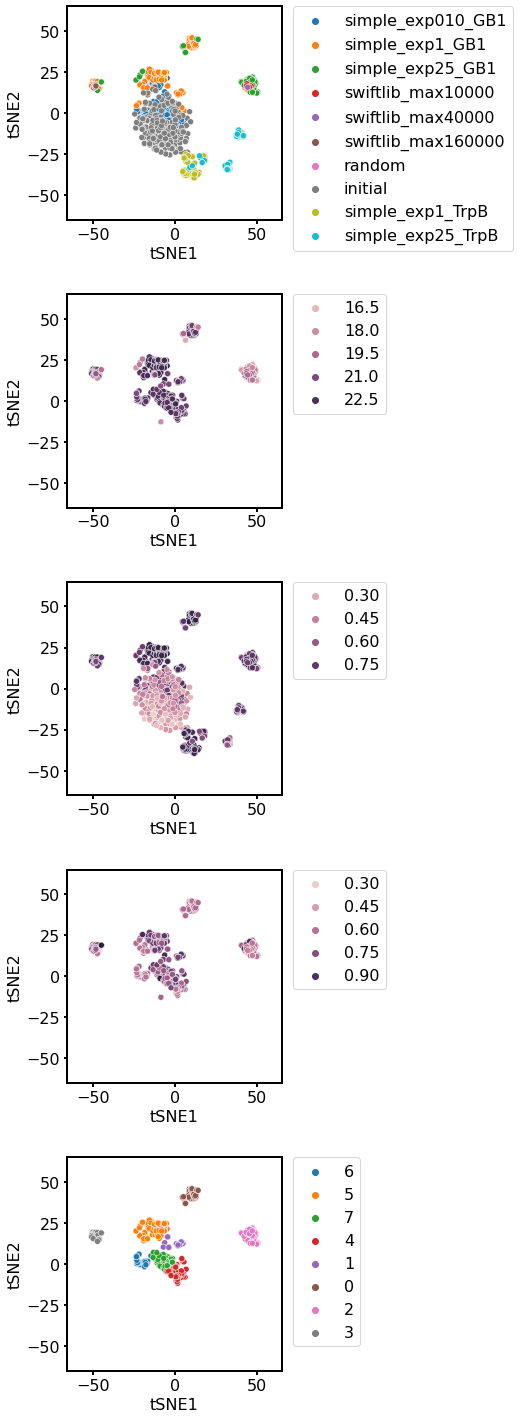

In [19]:
font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

plt.figure(figsize=(30, 20))


columns = ['descriptor', 'Weighted Full exp1','Weighted Simple exp1', 'Boosting Median Max', 'cluster']
#columns = ['descriptor']

for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    sns.scatterplot(data=df, x = 'tSNE1', y = 'tSNE2', hue=column)#, hue_order=order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlim(-66, 65)
    plt.ylim(-65, 65)

plt.tight_layout()

In [13]:
top_df = df.sort_values('Weighted Full',ascending = False).groupby('descriptor').head(10)
top_df

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,...,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,descriptor,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan,tSNE1,tSNE2,cluster
55,7.0,NDYNDYRVHDNY,248832.0,14256,0.953057,0.742989,0.984401,0.569193,0.217500,0.022110,...,0.712800,0.024314,0.598484,simple_exp010_GB1,NaN,NaN,NaN,-7.898722,0.328540,7
51,187.0,NDCVDBDVTDNY,69984.0,13728,0.951776,0.748275,0.981875,0.594167,0.191354,0.019071,...,0.723257,0.020984,0.625313,simple_exp010_GB1,NaN,NaN,NaN,0.903997,-0.236550,4
47,20.0,NDYVDSRVBDNY,186624.0,15444,0.950041,0.731145,0.983021,0.551172,0.205625,0.016710,...,0.705767,0.018667,0.581048,simple_exp010_GB1,NaN,NaN,NaN,-7.763072,-0.194548,7
59,91.0,NDYDNTDVTDNY,62208.0,11616,0.951298,0.752629,0.980495,0.599245,0.197057,0.021405,...,0.725016,0.023476,0.633719,simple_exp010_GB1,NaN,NaN,NaN,-5.195017,3.249048,7
50,144.0,NDYVDBNRCDBB,139968.0,14976,0.944310,0.700917,0.981953,0.488568,0.160937,0.017710,...,0.713171,0.019226,0.618097,simple_exp010_GB1,NaN,NaN,NaN,5.142442,-6.031890,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,60.0,MNRRBMBMNSYW,36864.0,2016,0.401962,0.401962,0.802760,0.303047,0.077604,0.008051,...,NaN,NaN,NaN,initial,NaN,NaN,NaN,-1.675517,4.572345,NaN
6,193.0,MBRKYNRBRSRV,27648.0,1260,0.382765,0.382765,0.791458,0.188568,0.070781,0.005561,...,NaN,NaN,NaN,initial,NaN,NaN,NaN,-10.853663,-20.528147,NaN
7,70.0,MBNKWDWKNNDR,110592.0,4851,0.311682,0.311682,0.635859,0.167552,0.028646,0.004273,...,NaN,NaN,NaN,initial,NaN,NaN,NaN,-9.986073,-14.511632,NaN
8,125.0,MYRBYNRVYSMR,18432.0,720,0.362150,0.362150,0.750729,0.241458,0.099323,0.012276,...,NaN,NaN,NaN,initial,NaN,NaN,NaN,-12.954751,-0.889869,NaN


In [14]:
top_df[top_df['descriptor'] == 'simple_exp010_GB1']

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,...,Triad Rank Expectation,Fitness Expectation,Fitness Rank Expectation,descriptor,Unnamed: 0.1,Weighted Full MSA Manhattan,Unweighted Full MSA Manhattan,tSNE1,tSNE2,cluster
55,7.0,NDYNDYRVHDNY,248832.0,14256,0.953057,0.742989,0.984401,0.569193,0.217500,0.022110,...,0.712800,0.024314,0.598484,simple_exp010_GB1,NaN,NaN,NaN,-7.898722,0.328540,7
51,187.0,NDCVDBDVTDNY,69984.0,13728,0.951776,0.748275,0.981875,0.594167,0.191354,0.019071,...,0.723257,0.020984,0.625313,simple_exp010_GB1,NaN,NaN,NaN,0.903997,-0.236550,4
47,20.0,NDYVDSRVBDNY,186624.0,15444,0.950041,0.731145,0.983021,0.551172,0.205625,0.016710,...,0.705767,0.018667,0.581048,simple_exp010_GB1,NaN,NaN,NaN,-7.763072,-0.194548,7
59,91.0,NDYDNTDVTDNY,62208.0,11616,0.951298,0.752629,0.980495,0.599245,0.197057,0.021405,...,0.725016,0.023476,0.633719,simple_exp010_GB1,NaN,NaN,NaN,-5.195017,3.249048,7
50,144.0,NDYVDBNRCDBB,139968.0,14976,0.944310,0.700917,0.981953,0.488568,0.160937,0.017710,...,0.713171,0.019226,0.618097,simple_exp010_GB1,NaN,NaN,NaN,5.142442,-6.031890,4
69,127.0,NDYRNSRVBDNY,165888.0,14256,0.948437,0.722658,0.982682,0.535573,0.195208,0.015903,...,0.695372,0.017990,0.573508,simple_exp010_GB1,NaN,NaN,NaN,-6.658900,0.649060,7
70,62.0,NDYRNSRVBDBS,124416.0,15552,0.945371,0.712084,0.982135,0.526589,0.193490,0.019729,...,0.724420,0.020270,0.581925,simple_exp010_GB1,NaN,NaN,NaN,-6.067544,0.613656,7
62,143.0,NDCDNYRVHDBK,93312.0,14256,0.946801,0.725678,0.981276,0.550312,0.208672,0.025112,...,0.739431,0.025779,0.601309,simple_exp010_GB1,NaN,NaN,NaN,-6.000396,1.385970,7
61,154.0,NDCDNYRVBDNY,124416.0,13068,0.949285,0.736065,0.981198,0.556953,0.209922,0.020748,...,0.708052,0.023307,0.591219,simple_exp010_GB1,NaN,NaN,NaN,-7.264971,1.415111,7
64,182.0,NDYDBKNRYDNY,165888.0,12672,0.945085,0.699463,0.982266,0.472318,0.155495,0.015575,...,0.672376,0.017268,0.606364,simple_exp010_GB1,NaN,NaN,NaN,1.683445,-4.551356,4


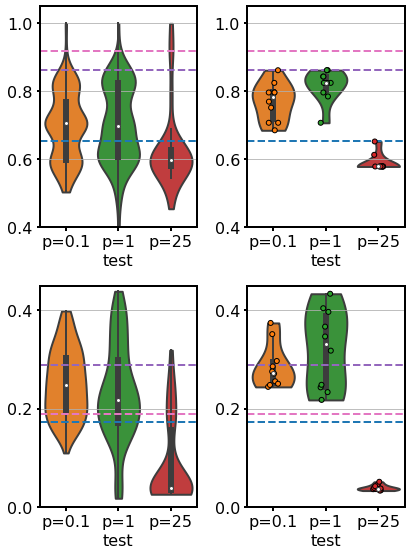

In [24]:
plt.figure(figsize=(6, 8))

#ynames = ['Sampled Median Max', 'Sampled Median Mean', 'Boosting Median Max', 'Boosting Median Mean']
ynames = ['Boosting Median Max', 'Boosting Median Mean']
order = ['simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1']
colors = ['tab:orange', 'tab:green', 'tab:red']

for j, yname in enumerate(ynames):

    plt.subplot(2, 2, 2*j + 1)
    #sns.stripplot(data=df, x='descriptor', y=yname,linewidth=1,edgecolor='black', order=order, jitter=True, dodge=True, palette=colors)
    ax = sns.violinplot(data=df, x='descriptor', y=yname, order= order, scale='width', cut=0, palette=colors)
    plt.grid(axis='y')
    #plt.xticks([])
    ax.set_xticklabels(['p=0.1', 'p=1', 'p=25'])
    plt.xlabel('test')
    plt.ylabel('')
    if j == 1:
        plt.ylim([0, 0.45])
        plt.yticks([0, 0.2, 0.4])

    else:
        plt.ylim([0.4, 1.05])
        plt.yticks([0.4, 0.6, 0.8, 1.0])
    
    plt.axhline(y=df[df['descriptor'] == 'random'][yname].values, linewidth=2, linestyle='--', color='tab:blue')

    if yname == 'Boosting Median Max':
        plt.axhline(y=median_maxes[3], linewidth=2, linestyle='--', color='tab:purple')
        plt.axhline(y=median_maxes[4], linewidth=2, linestyle='--', color='tab:pink')
    else:
        plt.axhline(y=median_means[3], linewidth=2, linestyle='--', color='tab:purple')
        plt.axhline(y=median_means[4], linewidth=2, linestyle='--', color='tab:pink')

    plt.subplot(2, 2, 2*j + 2)
    sns.stripplot(data=top_df, x='descriptor', y=yname,linewidth=1,edgecolor='black', order=order, dodge=True, palette=colors)
    ax = sns.violinplot(data=top_df, x='descriptor', y=yname, order=order[:3],scale='width', cut=0, palette=colors)
    ax.set_xticklabels(['p=0.1', 'p=1', 'p=25'])
    plt.grid(axis='y')
    #plt.xticks()
    plt.xlabel('test')
    plt.ylabel('')
    if j == 1:
        plt.ylim([0, 0.45])
        plt.yticks([0, 0.2, 0.4])
    else:
        plt.ylim([0.4, 1.05])
        plt.yticks([0.4, 0.6, 0.8, 1.0])
    
    plt.axhline(y=df[df['descriptor'] == 'random'][yname].values, linewidth=2, linestyle='--', color='tab:blue')
    if yname == 'Boosting Median Max':
        plt.axhline(y=median_maxes[3], linewidth=2, linestyle='--', color='tab:purple')
        plt.axhline(y=median_maxes[4], linewidth=2, linestyle='--', color='tab:pink')
    else:
        plt.axhline(y=median_means[3], linewidth=2, linestyle='--', color='tab:purple')
        plt.axhline(y=median_means[4], linewidth=2, linestyle='--', color='tab:pink')

plt.tight_layout()
plt.savefig('violin.svg')

In [23]:
df[df['Unweighted Full'] > 36]

,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Boosting Median Max,Boosting Median Mean
25,VNSNNSKSCNNS,98304.0,28224,0.671738,0.671666,0.928724,0.60362,0.235755,0.020818,0.573387,21.343385,36.966438,0.825004,0.292321


### Visualizing the performance of each library

In [8]:
results = np.load('/home/jyang4/repos/DeCOIL/MLDE_lite/saved/boosting_top_GB1/mlde_results.npy', allow_pickle=True)

maxes = results.item()['maxes']
means = results.item()['means']
ndcgs = results.item()['ndcgs']
top_seqs = results.item()['top_seqs']
labelled = results.item()['labelled']
unique = results.item()['unique']

maxes2 = maxes.reshape(maxes.shape[3], maxes.shape[4]).T
means2 = means.reshape(means.shape[3], means.shape[4]).T
ndcgs2 = ndcgs.reshape(ndcgs.shape[3], ndcgs.shape[4]).T
unique2 = unique.reshape(unique.shape[3], unique.shape[4]).T

0.6840384557614887
0.20651645713842398


Text(0.5, 0, 'Optimized Libraries')

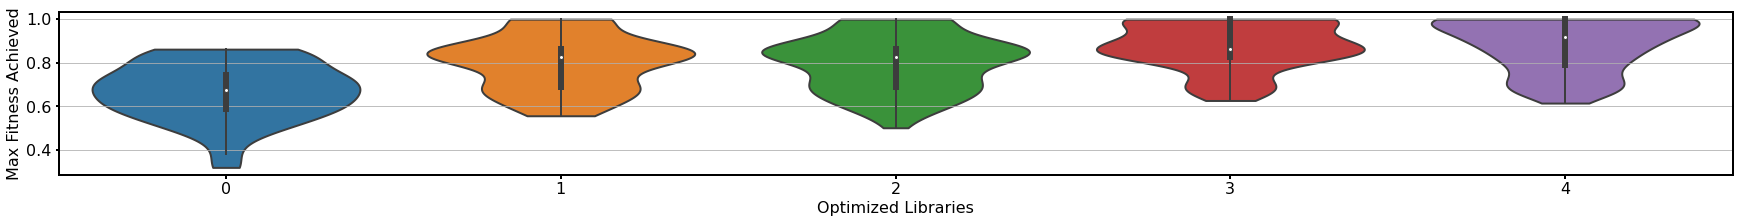

In [189]:
#MLDE violin plots
print(np.mean(df['Boosting Median Max']))
print(np.mean(df['Boosting Median Mean']))

plt.figure(figsize = (30, 3))
ax = sns.violinplot(data=maxes2, scale='width', cut=0)
#ax.set_xticklabels(['Random', 'Top 32000', 'Top 16000', 'Top 8000', 'Top 4000'])
#ax.set_xticklabels(['288', '336', '360', '372', '384'])
plt.grid(axis = 'y')
plt.ylabel('Max Fitness Achieved')
plt.xlabel('Optimized Libraries')
#plt.savefig('all_mix2_violin.jpg', dpi=500)

In [10]:
median_maxes = np.median(maxes2, axis = 0)
median_maxes

array([0.67711093, 0.82500438, 0.82500438, 0.86233688, 0.91819031])

In [11]:
median_means = np.median(means2, axis = 0)
median_means

array([0.17697801, 0.23282166, 0.22614017, 0.28824363, 0.18854199])

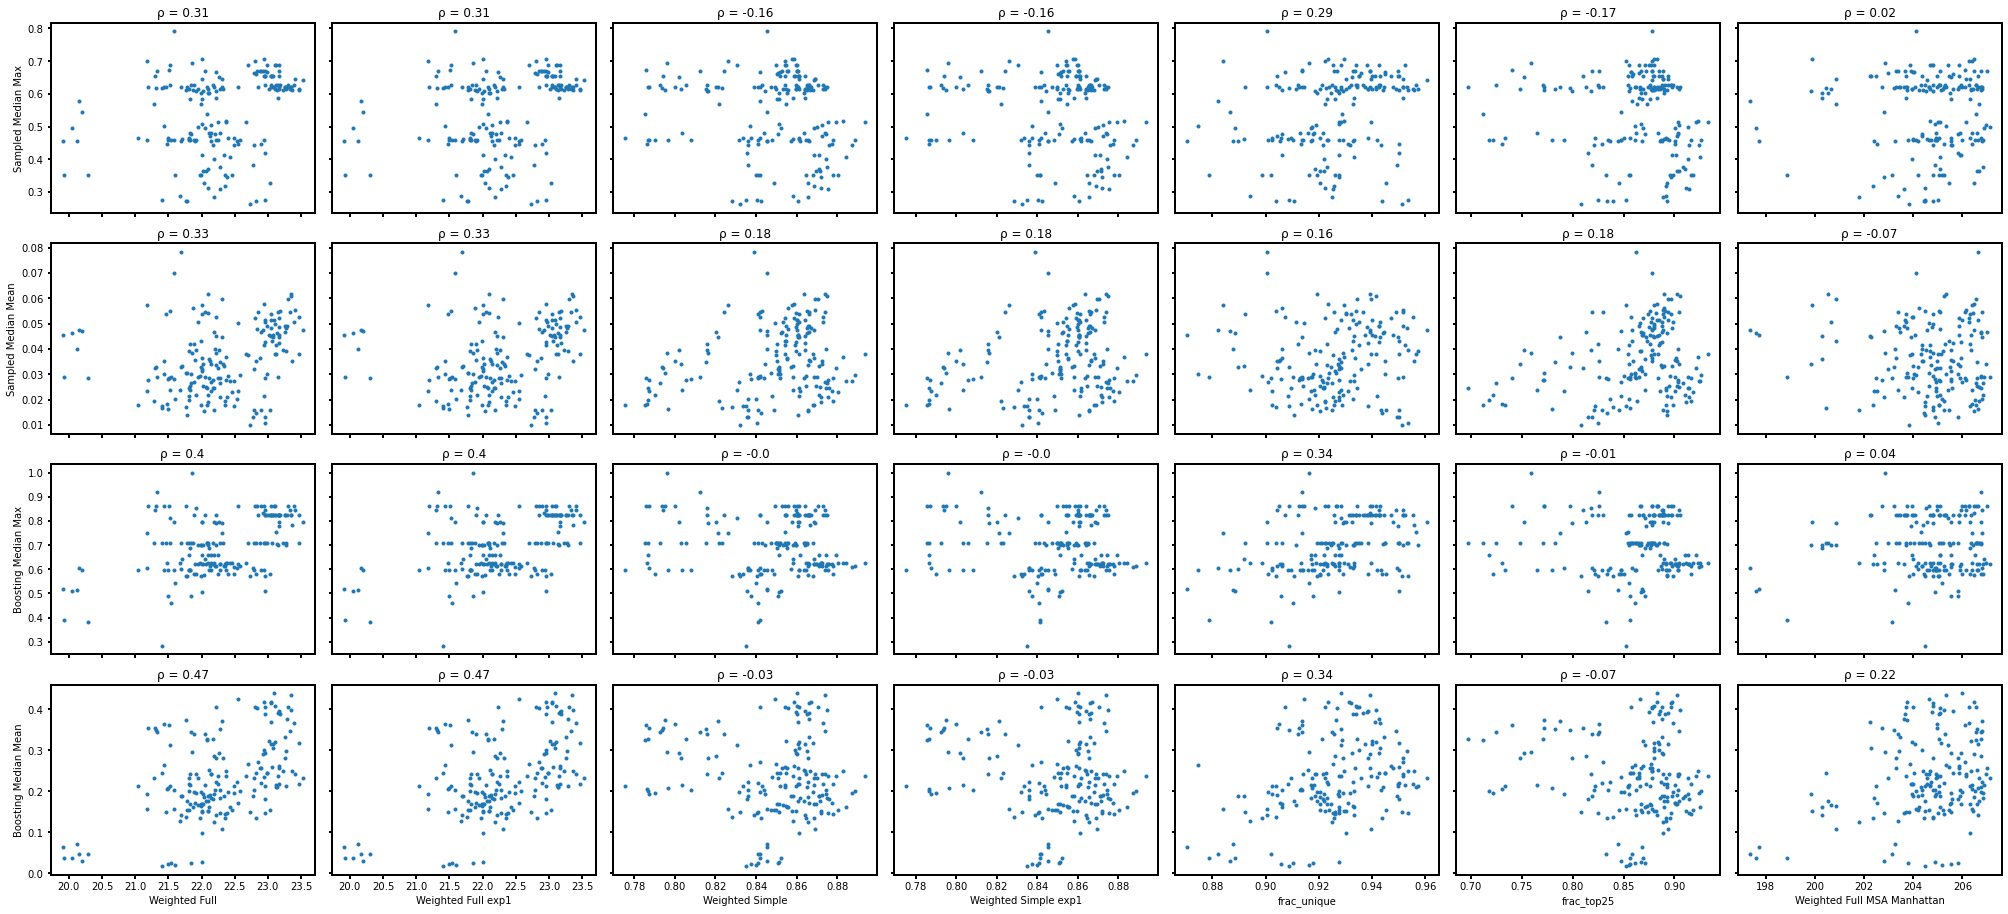

In [5]:
#correlation plots
df_subset = df[df['descriptor'] == 'simple_exp1_GB1']

xnames = ['Weighted Full', 'Weighted Full exp1', 'Weighted Simple', 'Weighted Simple exp1', 'frac_unique', 'frac_top25', 'Weighted Full MSA Manhattan']
ynames = ['Sampled Median Max', 'Sampled Median Mean', 'Boosting Median Max', 'Boosting Median Mean']

fig, axs = plt.subplots(len(ynames), len(xnames), figsize = (4*len(xnames), 3.2*len(ynames)))

for j, yname in enumerate(ynames):
    for i, xname in enumerate(xnames):

        x = df_subset[xname].values
        y = df_subset[yname].values

        # order = coverages.argsort()
        # ranks1 = order.argsort()
        plt.subplot(len(ynames),len(xnames), len(xnames)*(j) + i +1)
        plt.plot(x, y, '.')
        #plt.plot(x_random/384, y_random, 'k-')
        #plt.plot(1, y_triad_4000, 'r.')

        if j == len(ynames) - 1:
            plt.xlabel(xname)
        else:
            axs[j, i].set_xticklabels([])

        if i == 0:
            plt.ylabel(yname)
        else:
            axs[j, i].set_yticklabels([])
            
        plt.title('\u03C1 = ' + str(round(spearmanr(x, y)[0],2)))

plt.tight_layout()

In [3]:
fitness_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/fitness.csv')

#to calculate coverage for a few library sizes
with open('/home/jyang4/repos/StARDUST/dclo/configs/coverage_DEFAULT.json', 'r') as f:
    config = json.load(f)

x_random = np.array([240, 384])
y_random = []
y_triad_4000 = []

for n in x_random:
    oracle = Oracle(config['data_config'], config['opt_config'], verbose = True)
    samples = fitness_df['Combo'].sample(n=n, random_state=42).values
    scores, unweighted_scores, raw_scores, counts, diversity, _ = oracle.aas2zs(samples)
    y_random.append(unweighted_scores)
    print(scores)
    print(unweighted_scores)
    print(raw_scores)

subset_df = fitness_df.sort_values(by='Triad-FixedBb-dG', ascending = False)[:4000]
samples = subset_df['Combo'].sample(n=384, random_state=42).values
scores, unweighted_scores, raw_scores, counts, diversity, _ = oracle.aas2zs(samples)
y_triad_4000.append(unweighted_scores)
print(scores)
print(unweighted_scores)
print(raw_scores)
    

0.9169032240906435
25.98055943117518
0.28561386718750015
1.4456167526093486
40.78156010658663
0.47262626953125
6.014256749661077
37.7897223688643
0.978252571614584


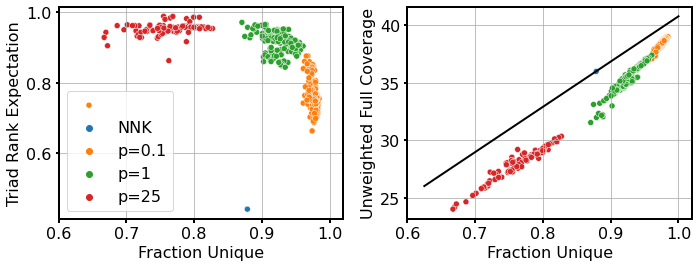

In [55]:
plt.figure(figsize=(10, 4))
order = ['random', 'simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1']
df_subset = df[df['descriptor'].isin(order)]

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_subset, x = 'frac_unique', y = 'Triad Rank Expectation', hue='descriptor', hue_order=order)
plt.legend(['','NNK', 'p=0.1', 'p=1', 'p=25'])
plt.xlim([0.6, 1.02])
plt.xlabel('Fraction Unique')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot([240/384, 384/384], [26, 40.8], '-k' )
#triad from top 4000, just one point, should sample a few to get statistics
#plt.plot([384/384], [37.8], 'sk' )

sns.scatterplot(data=df_subset, x = 'frac_unique', y = 'Unweighted Full', hue='descriptor', hue_order=order, legend=False)
plt.xlim([0.6, 1.02])
plt.xlabel('Fraction Unique')
plt.ylabel('Unweighted Full Coverage')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.grid()
plt.savefig('tradeoff.svg')

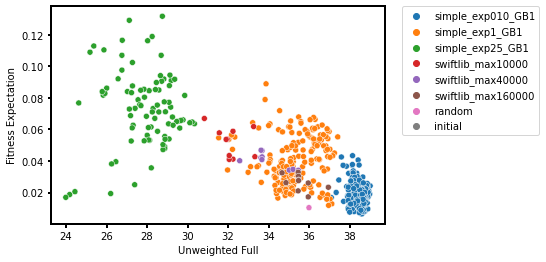

In [68]:
df_subset = df[~df['descriptor'].isin(['simple_exp1_TrpB', 'simple_exp25_TrpB'])]
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Fitness Expectation', hue='descriptor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [226]:
df_subset.columns

Index(['Unnamed: 0', 'Template1', 'Library Size', 'AA Library Size',
       'Weighted Simple', 'Weighted Simple exp1', 'frac_unique', 'frac_top25',
       'frac_top5', 'Sampled Median Mean', 'Sampled Median Max',
       'Weighted Full', 'Unweighted Full', 'Weighted Full exp1',
       'Boosting Median Max', 'Boosting Median Mean', 'Triad Rank Expectation',
       'Fitness Expectation', 'Fitness Rank Expectation', 'descriptor',
       'Unnamed: 0.1', 'Weighted Full MSA Manhattan',
       'Unweighted Full MSA Manhattan', 'tSNE1', 'tSNE2', 'cluster'],
      dtype='object')

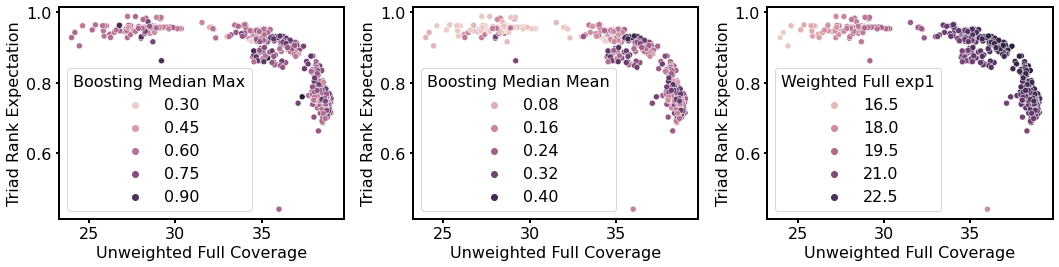

In [56]:
plt.figure(figsize=(15, 4))
order = ['random', 'simple_exp010_GB1', 'simple_exp1_GB1', 'simple_exp25_GB1']
df_subset = df[df['descriptor'].isin(order)]

plt.subplot(1, 3, 1)
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Triad Rank Expectation', hue='Boosting Median Max', hue_order=order)
#plt.xlim([0.6, 1.02])
plt.xlabel('Unweighted Full Coverage')

plt.subplot(1, 3, 2)
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Triad Rank Expectation', hue='Boosting Median Mean', hue_order=order)
#plt.xlim([0.6, 1.02])
plt.xlabel('Unweighted Full Coverage')
plt.tight_layout()

plt.subplot(1, 3, 3)
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Triad Rank Expectation', hue='Weighted Full exp1', hue_order=order)
#plt.xlim([0.6, 1.02])
plt.xlabel('Unweighted Full Coverage')
plt.tight_layout()

plt.savefig('pareto.svg')

Weighted full is generally a more robust predictor, but weighted simple is just as good when there is not enough exploitation occuring. If there is too much exploitation, weighted full is better because it balances out exploration.